In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import (
    get_optimizer_oracles,
    proximal_accelerated_gradient,
    project_to_lower_with_positive_diag,
    warm_start
)
from plotting_utilities import get_metrics, patternify_Ls, one_example_prs
import scanpy as sc
import igraph as ig

# Prevent Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Make sure everything still works

In [2]:
np.random.seed(0)

# Let's generate a 50 x 50 matrix from our Cartesian LGAM model in which the
# ground truth graphs have only 10% nonzero elements.
dims = (50, 50)
sparsity = 0.1
Ls, L_patterns = generate_Ls(dims, sparsity=sparsity)
X = generate_sylvester_data(Ls, normalize=True, source_distribution=np.random.normal)

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.5e-6
objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=5000,
    tol=1e-20
)

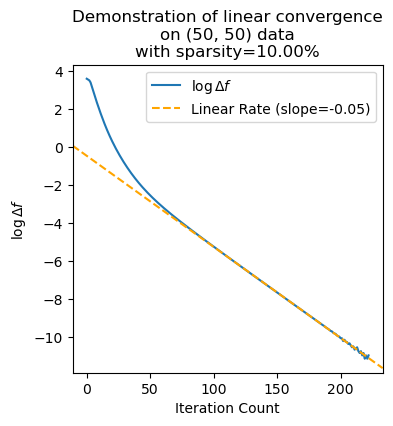

In [3]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

# Fit a line through the data to demonstrate it really is linear
linear_data = iterations > 100
slope, intercept = np.polyfit(iterations[linear_data], del_f[linear_data], deg=1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of linear convergence\non {dims} data\nwith {sparsity=:.2%}")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
ax.axline(xy1=(0, intercept), slope=slope, linestyle='--', color='orange', label=f'Linear Rate ({slope=:.2f})')
ax.legend()
pass

Run on real data

In [4]:
blob_data = sc.datasets.blobs(n_variables=50, n_observations=50, n_centers=5)
dataset = blob_data.X
dataset /= (dataset**2).sum()
dataset.shape

(50, 50)

In [5]:
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.9e-5
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-20
)

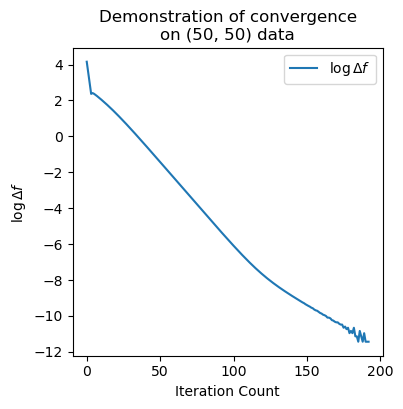

In [6]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of convergence\non {dims} data")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
ax.legend()
pass

In [7]:
((Ls[0] != 0).sum() - Ls[0].shape[0]) / (Ls[0].shape[0]**2 - Ls[0].shape[0]) * 2

np.float64(0.1836734693877551)

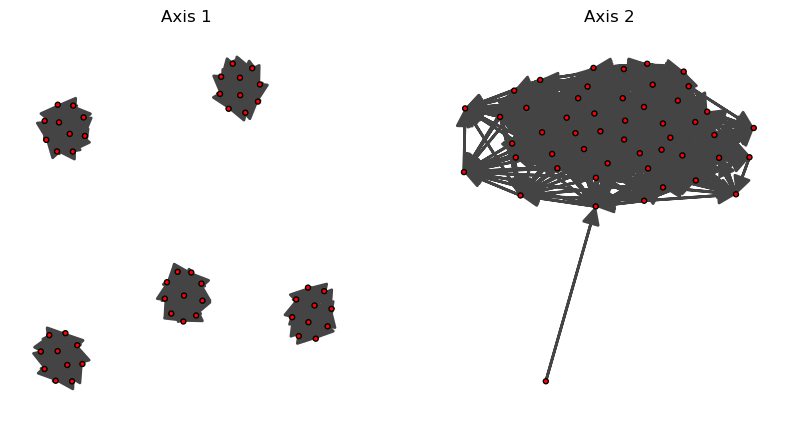

In [8]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ig.plot(
    ig.Graph.Weighted_Adjacency(Ls[0]).simplify(),
    target=ax1,
    vertex_size=5
)
ig.plot(
    ig.Graph.Weighted_Adjacency(Ls[1]).simplify(),
    target=ax2,
    vertex_size=5
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

In [9]:
krum_data = sc.datasets.krumsiek11()
krum = krum_data.X
krum /= (krum**2).sum()
krum_data

/Users/baileyandrew/mambaforge/envs/Cartesian-LGAM/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights'

In [10]:
dims = krum.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.6e-3 #0.5e-3 ~1.9%
objective, gradient, proximal = get_optimizer_oracles(krum, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

In [11]:
((Ls[0] != 0).sum() - Ls[0].shape[0]) / (Ls[0].shape[0]**2 - Ls[0].shape[0]) * 2

np.float64(0.0290835289514867)

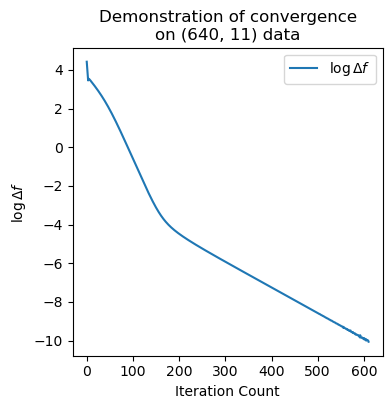

In [12]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of convergence\non {dims} data")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
ax.legend()
pass

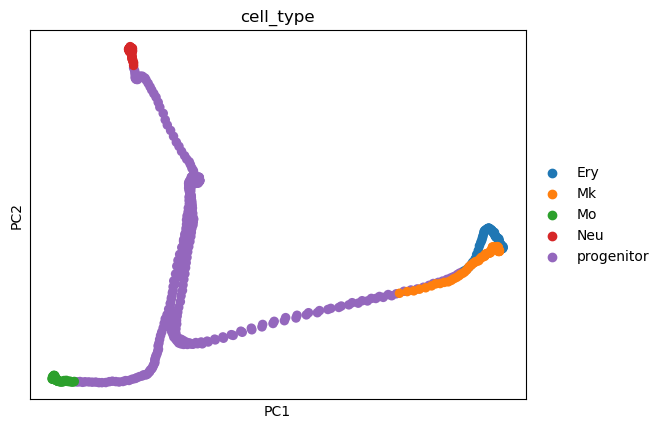

In [13]:
sc.pp.pca(krum_data)
sc.pl.pca(krum_data, color='cell_type')

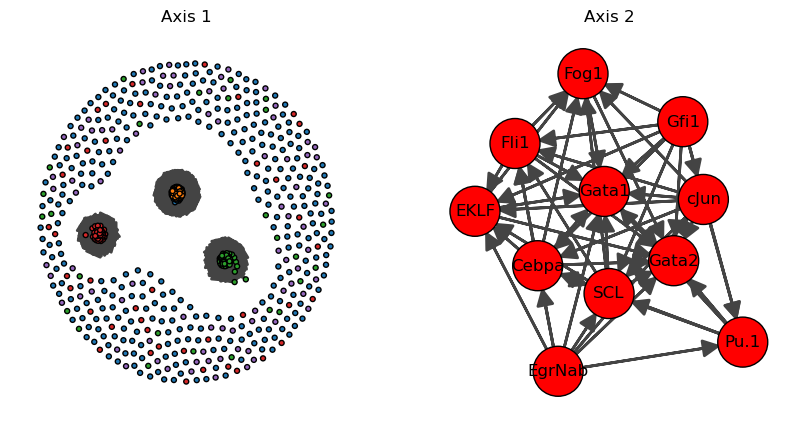

In [14]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

cell_graph = ig.Graph.Weighted_Adjacency(Ls[0]).simplify()
cell_types = krum_data.obs['cell_type']
type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
cell_graph.vs["edge_color"] = cell_graph.vs["color"]

gene_graph = ig.Graph.Weighted_Adjacency(Ls[1]).simplify()
gene_graph.vs["label"] = krum_data.var_names

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

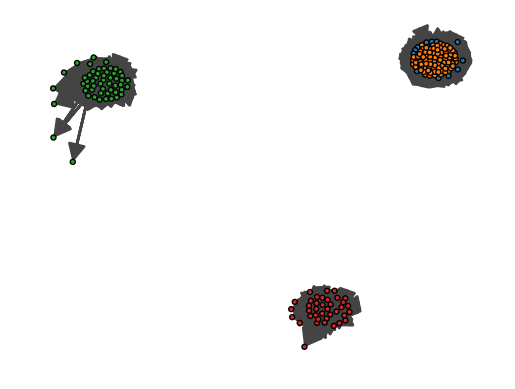

In [15]:
non_singletons = [v.index for v in cell_graph.vs if cell_graph.degree(v) > 0]
g_no_singletons = cell_graph.induced_subgraph(non_singletons)

fig, ax = plt.subplots()
ig.plot(
    g_no_singletons,
    target=ax,
    vertex_size=5
)

In [16]:
Ls_cells = [L.copy() for L in Ls]

In [17]:
dims = krum.shape
L_init = [L.copy() for L in Ls_cells]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.6e-2 #0.5e-3 ~1.9%
objective, gradient, proximal = get_optimizer_oracles(krum, frobreg=frobreg, glassoregs=glassoreg)

Ls_genes, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

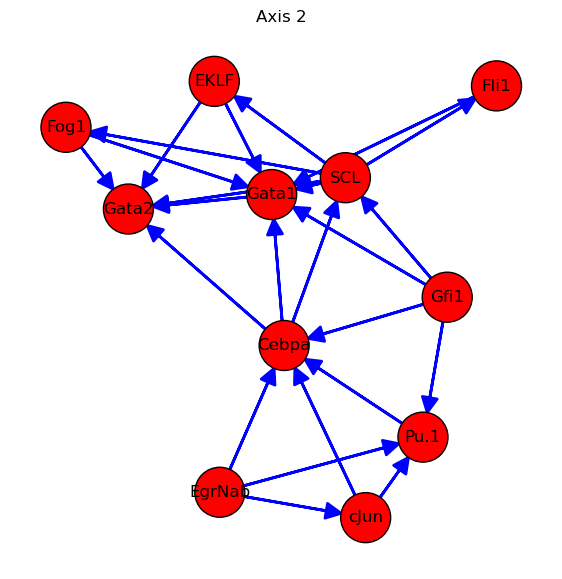

In [18]:
# It'll take a couple seconds to draw this graph.
fig, ax2 = plt.subplots(figsize=(7, 7), ncols=1)


gene_graph = ig.Graph.Weighted_Adjacency(Ls_genes[1] - np.diag(np.diag(Ls_genes[1])))
gene_graph.vs["label"] = krum_data.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    edge_color=gene_graph.es["color"],
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

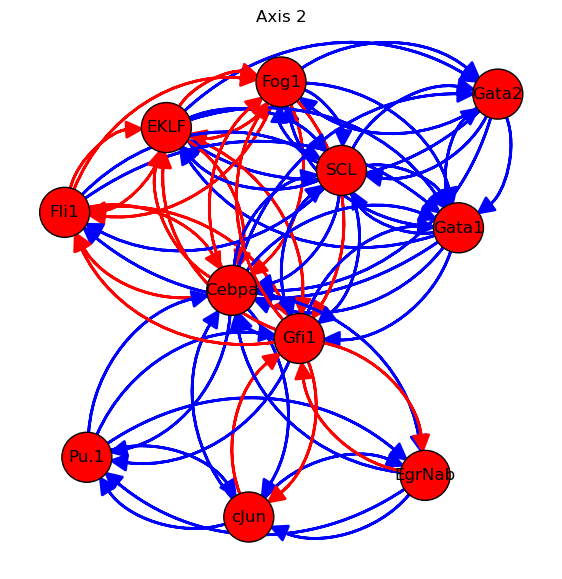

In [19]:
# It'll take a couple seconds to draw this graph.
fig, ax2 = plt.subplots(figsize=(7, 7), ncols=1)

Psi = Ls_genes[1] @ Ls_genes[1].T
np.fill_diagonal(Psi, 0)
gene_graph = ig.Graph.Weighted_Adjacency(Psi)
gene_graph.vs["label"] = krum_data.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    edge_color=gene_graph.es["color"],
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

In [114]:
ordered_krum = krum_data[:, ["Gata1", "Gata2", "SCL", "Fog1", "EKLF", "Fli1", "Cebpa", "Pu.1", "cJun", "EgrNab", "Gfi1"]]

r1 = 1
r2 = 0
r3 = -1
r4 = -2

gene_layout = [
    (0, r2), (1, r1), (1, r3), (-1, r1), (-0.5, r4), (-2.5, r4), (4.5, r1), (2, r2), (2.5, r3), (3.5, r4), (5.5, r4)
]

In [ ]:
dims = ordered_krum.X.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.1e-1 #0.1e-1
objective, gradient, proximal = get_optimizer_oracles(ordered_krum.X, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

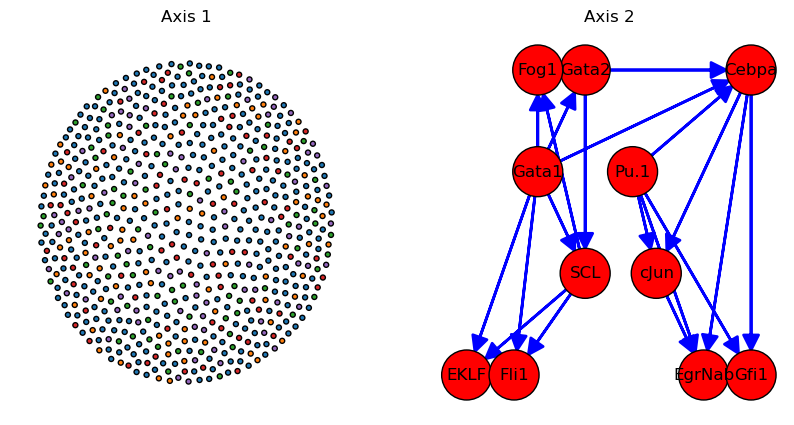

In [72]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls[0].T).simplify()
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
cell_graph.vs["edge_color"] = cell_graph.vs["color"]

gene_graph = ig.Graph.Weighted_Adjacency(Ls[1].T - np.diag(np.diag(Ls[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

Negative regulation due to zero inflation?

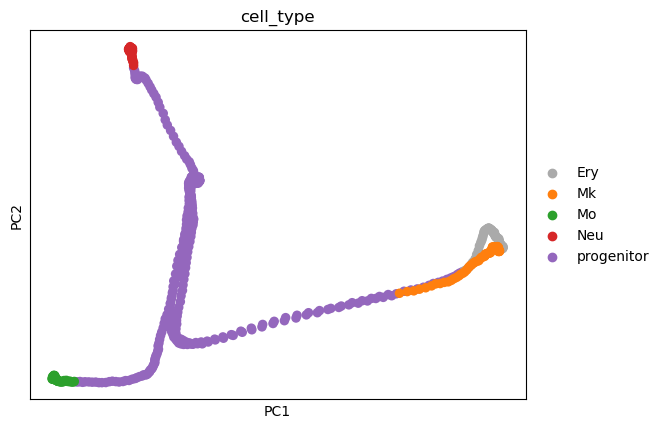

In [150]:
ordered_krum.uns['cell_type_colors'][0] = '#aaaaaa'
sc.pl.pca(ordered_krum, color='cell_type')

In [122]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = [3e-2, 1.5e0] # [3e-2, 1.5e0]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


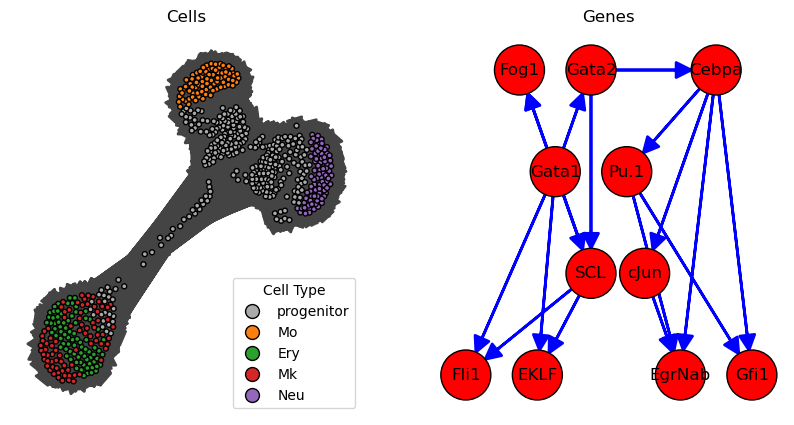

In [162]:
# It'll take a couple seconds to draw this graph.
import matplotlib.lines
import random

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls[0].T - np.diag(np.diag(Ls[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

gene_graph = ig.Graph.Weighted_Adjacency(Ls[1].T - np.diag(np.diag(Ls[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

pass